In [2]:
pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
ticker = "TSLA"
data = yf.download(ticker, start = "2022-11-17", end = "2023-11-17")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000
2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,76048900
2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92882700
2022-11-22,168.630005,170.919998,166.190002,169.910004,169.910004,78452300
2022-11-23,173.570007,183.619995,172.500000,183.199997,183.199997,109536700
...,...,...,...,...,...,...
2023-11-10,210.029999,215.380005,205.690002,214.649994,214.649994,130994000
2023-11-13,215.600006,225.399994,211.610001,223.710007,223.710007,140447600
2023-11-14,235.029999,238.139999,230.720001,237.410004,237.410004,149771600


In [5]:
#function to calculate simple moving average
def SMA(data, period = 30, column = 'Close'):
  return data[column].rolling(window = period).mean()

In [6]:
#build and show the dataset
data['SMA'] = SMA(data,21)
data['Simple_Returns'] = data.pct_change(1)['Close']
data['Log_Returns'] = np.log(1+data['Simple_Returns'])
data['Ratios'] = data['Close']/data['SMA']

In [7]:
data

,Open,High,Low,Close,Adj Close,Volume,SMA,Simple_Returns,Log_Returns,Ratios
Date,,,,,,,,,,
2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000,NaN,NaN,NaN,NaN
2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,76048900,NaN,-0.016269,-0.016403,NaN
2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92882700,NaN,-0.068372,-0.070822,NaN
2022-11-22,168.630005,170.919998,166.190002,169.910004,169.910004,78452300,NaN,0.012152,0.012079,NaN
2022-11-23,173.570007,183.619995,172.500000,183.199997,183.199997,109536700,NaN,0.078218,0.075310,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-10,210.029999,215.380005,205.690002,214.649994,214.649994,130994000,219.965238,0.022240,0.021996,0.975836
2023-11-13,215.600006,225.399994,211.610001,223.710007,223.710007,140447600,218.660000,0.042208,0.041342,1.023095
2023-11-14,235.029999,238.139999,230.720001,237.410004,237.410004,149771600,217.873810,0.061240,0.059438,1.089667


In [8]:
#getting some statistics on the ratio column
data['Ratios'].describe()

count    231.000000
mean       1.014470
std        0.126855
min        0.671263
25%        0.940020
50%        1.001696
75%        1.077514
max        1.382770
Name: Ratios, dtype: float64

In [10]:
percentiles = [15,20,50,80,85]
ratios = data['Ratios'].dropna()
percentile_values = np.percentile(ratios,percentiles)
percentile_values

array([0.88535022, 0.92402463, 1.00169577, 1.10509217, 1.14779472])

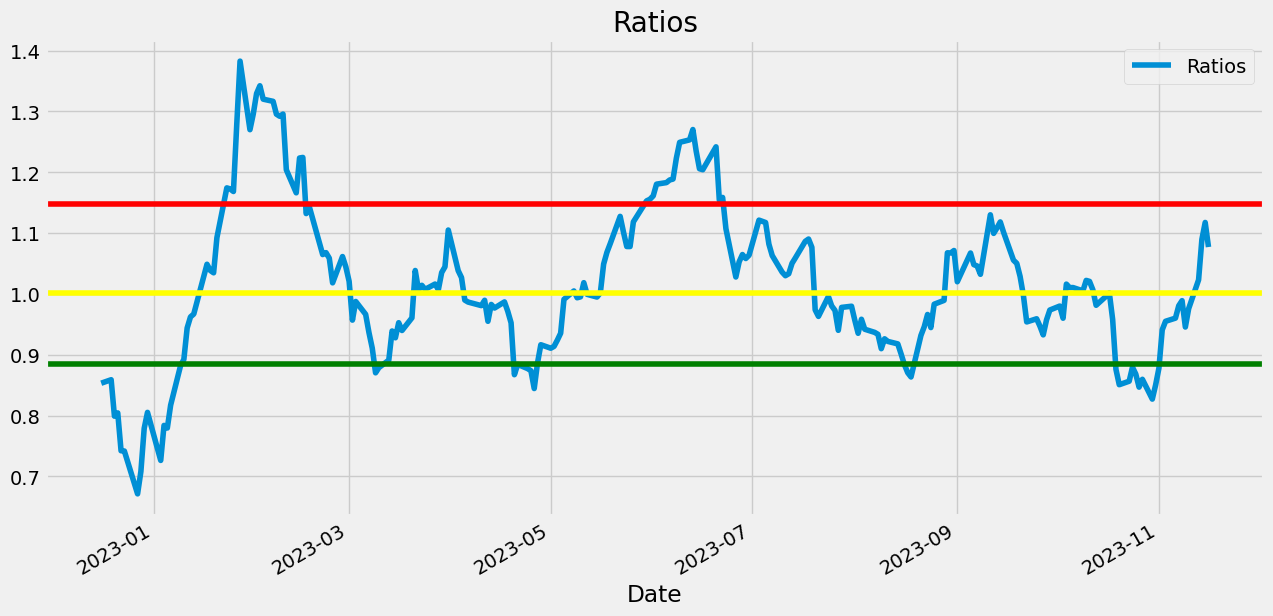

In [12]:
plt.figure(figsize = (14,7))
plt.title('Ratios')
data['Ratios'].dropna().plot(legend = True)
plt.axhline(percentile_values[0],c= 'green',label = '15th percentile')
plt.axhline(percentile_values[2],c= 'yellow',label = '50th percentile')
plt.axhline(percentile_values[-1],c= 'red',label = '85th percentile')

In [13]:
#creating buy and sell signals
sell = percentile_values[-1] #85th percentile threshold where we want to sell
buy = percentile_values[0] #15th percentile threshold where we want to buy

#put -1 where the ratio is greater than the percentile to sell and otherwise
data['Positions'] = np.where(data.Ratios > sell,-1,np.nan)
#put 1 where the ratio is less than the percentile to buy and put the current value otherwise
data['Positions'] = np.where(data.Ratios < buy, 1, data['Positions'])
#use ffill to fill the missing values in the data frame. ffill stands for forward fill
data['Positions'] = data['Positions'].ffill()

#Get the buy and sell signals
data['Buy'] = np.where(data.Positions == 1,data['Close'],np.nan)
data['Sell'] = np.where(data.Positions == -1,data['Close'], np.nan)




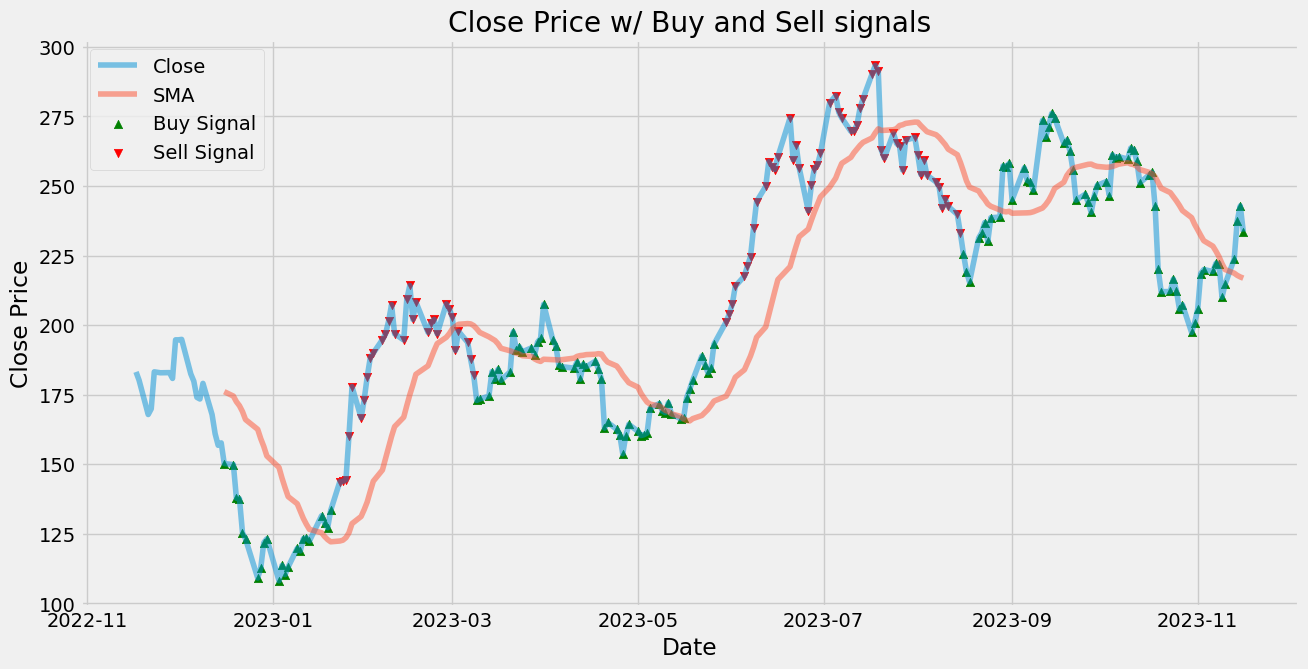

In [14]:
plt.figure(figsize = (14,7))
plt.title('Close Price w/ Buy and Sell signals')
plt.plot(data['Close'], alpha = 0.5, label = 'Close')
plt.plot(data['SMA'], alpha = 0.5, label = 'SMA')
plt.scatter(data.index, data['Buy'],color = 'green',label = 'Buy Signal',marker = '^',alpha = 1)
plt.scatter(data.index,data['Sell'],color = 'red',label = 'Sell Signal',marker = 'v',alpha = 1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [15]:
#calculating the returns for the mean reversion strategy
data['Strategy_Returns'] = data.Positions.shift(1)*data.Log_Returns
data['Strategy_Returns']

Date
2022-11-17         NaN
2022-11-18         NaN
2022-11-21         NaN
2022-11-22         NaN
2022-11-23         NaN
                ...   
2023-11-10    0.021996
2023-11-13    0.041342
2023-11-14    0.059438
2023-11-15    0.022614
2023-11-16   -0.038835
Name: Strategy_Returns, Length: 251, dtype: float64

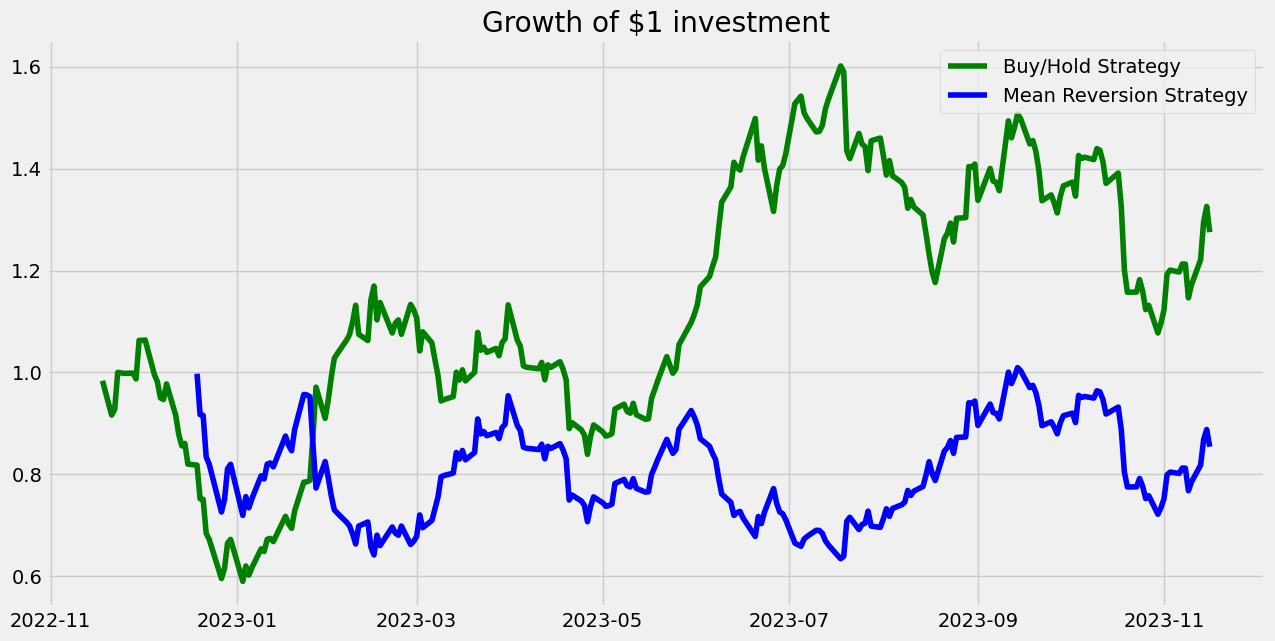

In [16]:
#plot the cumulative log returns and the cumulative mean reversion strategy
plt.figure(figsize = (14,7))
plt.title('Growth of $1 investment')
plt.plot(np.exp(data['Log_Returns'].dropna()).cumprod(),c='green',label = 'Buy/Hold Strategy')
plt.plot(np.exp(data['Strategy_Returns'].dropna()).cumprod(),c='blue',label = 'Mean Reversion Strategy')
plt.legend()


In [18]:
print('Buy and hold strategy returns : ',np.exp(data['Log_Returns'].dropna()).cumprod()[-1]-1)
print('Mean Reversion Strategy returns: ',np.exp(data['Strategy_Returns'].dropna()).cumprod()[-1]-1)


Buy and hold strategy returns :  0.2752634092535229
Mean Reversion Strategy returns:  -0.14566558218638137
